In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from textblob import TextBlob

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Angela\ANACONDA\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
import pandas as pd
larocheposay = pd.read_csv("tweets_larocheposay.csv")
larocheposay = larocheposay.drop(['Unnamed: 0', 'Date', 'User'], axis=1)

## Data Cleaning

In [3]:
larocheposay.head()

,Tweet
0,La Roche-Posay Toleriane Ultra Face and Eye Ma...
1,La Roche-Posay Substiane Riche Face Moisturize...
2,I don’t care much for scented skincare product...
3,La Roche-Posay Toleriane Purifying Foaming Fac...
4,Need to get my La roche posay again my skin is...


### Remove punctuation, special characters and lower casing

In [4]:
# 1 - Text cleaning
def clean_up(s):
    clean = re.sub(r'http\S+', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean).lower().strip()

def clean_up2(s):
    clean2 = re.sub(r'\W*\b\w{1,3}\b', '', s)
    return re.sub('[^A-Za-z ]+', ' ', clean2).lower().strip()

In [5]:
# In order to avoid errors, change type to string
larocheposay['Tweet'] = larocheposay['Tweet'].apply(str)  # change to string for avoiding errors

In [6]:
larocheposay['Tweet_Processed'] = larocheposay['Tweet'].apply(clean_up).apply(clean_up2)
larocheposay

,Tweet,Tweet_Processed
0,La Roche-Posay Toleriane Ultra Face and Eye Ma...,roche posay toleriane ultra face makeup remove...
1,La Roche-Posay Substiane Riche Face Moisturize...,roche posay substiane riche face moisturizer v...
2,I don’t care much for scented skincare product...,care much scented skincare products quite like...
3,La Roche-Posay Toleriane Purifying Foaming Fac...,roche posay toleriane purifying foaming facial...
4,Need to get my La roche posay again my skin is...,need roche posay again skin starting crack
...,...,...
19995,@DannyPsavage Me five minutes ago: “I need to ...,dannypsavage five minutes need save money righ...
19996,This la roche posay baume ada whitecast sikit ...,this roche posay baume whitecast sikit tekejut...
19997,"@ImSpeaking13 Was thinking cucumber, or rosema...",imspeaking thinking cucumber rosemary roche po...
19998,".@LaRochePosayUSA launched SOS “Save Our Skin""...",larocheposayusa launched save skin annual pub...


### Tokenize words and further clean-up text

In [7]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = larocheposay.Tweet_Processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

C:\Users\Angela\ANACONDA\lib\site-packages\botocore\httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


['roche', 'posay', 'toleriane', 'ultra', 'face', 'makeup', 'remover', 'travel', 'size', 'capsules', 'gkkhr']


### Phrase Modeling: Bigram and Trigram Models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [9]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['SA', 'link', '$', 'ohmybeautybank'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Angela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#pip install spacy

In [11]:
!python -m spacy download en_core_web_sm
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1][0][:30])

     --------------------------------------- 12.8/12.8 MB 50.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Angela\ANACONDA\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.F

In [12]:
data_words_bigrams

[['roche',
  'posay',
  'toleriane',
  'ultra',
  'face',
  'makeup_remover',
  'travel_size',
  'capsules',
  'gkkhr'],
 ['roche',
  'posay',
  'substiane_riche',
  'face',
  'moisturizer',
  'visible_density',
  'volume_replenishing',
  'anti_aging',
  'moisturizer',
  'care',
  'pack'],
 ['care',
  'much',
  'scented',
  'skincare',
  'products',
  'quite',
  'like',
  'scent',
  'roche',
  'posay',
  'serums'],
 ['roche',
  'posay',
  'toleriane',
  'purifying_foaming',
  'facial',
  'cleanser',
  'free',
  'face',
  'wash',
  'oily',
  'skin',
  'sensitive',
  'skin',
  'niac',
  'xlwrrpv'],
 ['need', 'roche', 'posay', 'skin', 'starting', 'crack'],
 ['stxrboy',
  'roche',
  'posay',
  'cleanser',
  'moisturizer',
  'paula_choice',
  'salicylic_acid',
  'break',
  'times_week'],
 ['roche',
  'posay',
  'pigmentclar_dark',
  'circles',
  'cream',
  'caffeine_brightens',
  'area_targets',
  'dark_circles',
  'furpqte'],
 ['thoughts', 'roche', 'posay', 'effaclar', 'cream'],
 ['need',


In [13]:
data_lemmatized

[['posay',
  'toleriane',
  'ultra',
  'face',
  'makeup_remover',
  'travel_size',
  'capsule',
  'gkkhr'],
 ['roche',
  'posay',
  'substiane_riche',
  'face',
  'moisturizer',
  'visible_density',
  'volume_replenishing',
  'anti_age',
  'moisturizer',
  'care',
  'pack'],
 ['care',
  'much',
  'scented',
  'skincare',
  'product',
  'quite',
  'scent',
  'roche',
  'posay',
  'serum'],
 ['posay',
  'toleriane',
  'purifying_foame',
  'facial',
  'cleanser',
  'free',
  'face',
  'wash',
  'oily',
  'skin',
  'sensitive'],
 ['need', 'roche', 'posay', 'skin', 'start', 'crack'],
 ['stxrboy',
  'roche',
  'posay',
  'cleanser',
  'moisturizer',
  'paula_choice',
  'salicylic_acid',
  'break'],
 ['roche',
  'posay',
  'pigmentclar_dark',
  'circle',
  'cream',
  'caffeine_brighten',
  'area_target',
  'dark_circle',
  'furpqte'],
 ['thought', 'roche', 'posay', 'effaclar', 'cream'],
 ['need',
  'roche',
  'posay',
  'hype',
  'inexpensive',
  'clear',
  'skin',
  'sooo',
  'much',
  'lov

### Data Transformation: Corpus and Dictionary

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

# It is creating a dictionary with the order of words and their frequency in the dataset
# For instance, if first word was able, it would indicate it appears 1 time in the dictionary

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


### Base Model

In [15]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

### View the topics in LDA model

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

### Compute Model Perplexity and Coherence Score

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

### Hyperparameter Tuning

In [18]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
coherence_model_lda

In [20]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_larocheposay.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [8:09:52<00:00, 54.43s/it]    


In [16]:
result = pd.read_csv("lda_tuning_results_larocheposay.csv")
result

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.466384
1,75% Corpus,2,0.01,0.31,0.446054
2,75% Corpus,2,0.01,0.61,0.447398
3,75% Corpus,2,0.01,0.9099999999999999,0.482658
4,75% Corpus,2,0.01,symmetric,0.463387
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.424352
536,100% Corpus,10,asymmetric,0.31,0.486802
537,100% Corpus,10,asymmetric,0.61,0.498621
538,100% Corpus,10,asymmetric,0.9099999999999999,0.427871


In [17]:
#calculate mean of points grouped by topics
topics = result.groupby('Topics')['Coherence'].mean()
topics

Topics
2     0.455836
3     0.428982
4     0.440928
5     0.430719
6     0.436083
7     0.434428
8     0.421901
9     0.427100
10    0.423093
Name: Coherence, dtype: float64

In [18]:
# Generated by OPEN AI 
import pandas as pd

data = {'Topics': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'Coherence': [0.455836, 0.428982, 0.440928, 0.430719, 0.436083, 0.434428, 0.421901, 0.427100, 0.423093]}

df = pd.DataFrame(data)

In [19]:
df

,Topics,Coherence
0,2,0.455836
1,3,0.428982
2,4,0.440928
3,5,0.430719
4,6,0.436083
5,7,0.434428
6,8,0.421901
7,9,0.427100
8,10,0.423093


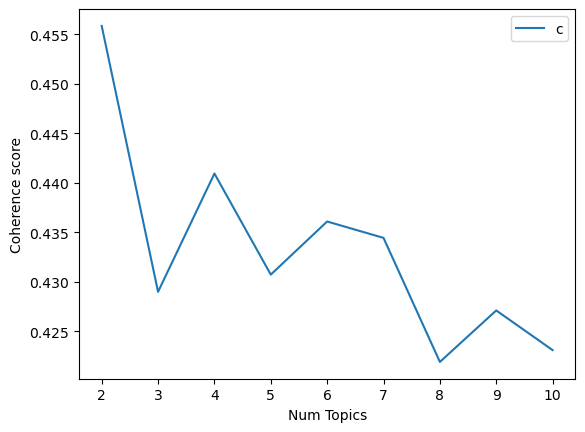

In [20]:
# Show graph -- fix it!
limit=40; start=2; step=6;
x = df['Topics']
y = df['Coherence']
plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Final Model

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R=30)
vis

C:\Users\Angela\ANACONDA\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060821  0.191996       1        1  59.287151
1      0.060821 -0.191996       2        1  40.712849, topic_info=                 Term         Freq         Total Category  logprob  loglift
1                face  2304.000000   2304.000000  Default  30.0000  30.0000
23           cleanser  2210.000000   2210.000000  Default  29.0000  29.0000
54          sunscreen  3045.000000   3045.000000  Default  28.0000  28.0000
41              cream  1600.000000   1600.000000  Default  27.0000  27.0000
10        moisturizer  1406.000000   1406.000000  Default  26.0000  26.0000
...               ...          ...           ...      ...      ...      ...
54          sunscreen  2759.597714   3045.650678   Topic2  -3.3295   0.8000
29               skin  2790.070254   4528.514733   Topic2  -3.3185   0.4143
4               posay  5509.783841  16409.142299   Topic2  -2.6381  -0.1927
12              roche  5101.423041  14868.652278   Topic2  -2.7151  -0.1711
1425  larocheposayusa   461.668618    553.399010   Topic2  -5.1175   0.7174

[107 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
162       1  0.001211      acne
162       2  0.998968      acne
60        1  0.999344      also
60        2  0.000908      also
127       1  0.000753  anthelio
...     ...       ...       ...
206       2  0.000906      well
74        1  0.999653      work
74        2  0.001340      work
315       1  0.997693     worth
315       2  0.003118     worth

[147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [23]:
pyLDAvis.save_html(vis, 'lda_visualization_larocheposay.html')